<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>



# Curso *Ingeniería de Características*

### Proyecto 2.1 *Contando Historias con Datos*


<p> Osiris Alejandro Izaguirre </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="150">
</p>

</center>

# Objetivo 

Realizar un tablero que cuente una historia a partir de un análisis exploratorio de datos. Esto se considera un resultado parcial importante en un proceso de ciencia de datos. Estos tableros permiten ampliar la discusión y el entendimiento con los usuarios de los productos de datos y ayudan a plantear mejor las preguntas, seleccionar mejor los modelos de estimación y/o pronóstico así como a especificar más claramente los productos a desarrollar.

In [57]:
%matplotlib inline
import pandas as pd
from pandas_profiling import ProfileReport
import sweetviz
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# EDA Automatico 

Generamos un Análisis Exploratorio de Datos de manera automática utilizando SweetViz en formato HTM con el código a continuación para revisar la distribución de los datos.

In [2]:
# Abrir data frames
seguridad_df = pd.read_parquet('https://github.com/osirisizs/Proyecto-Ingenieria-de-Caracteristicas/raw/main/seguridad_df.parquet')

#%% Probando pandas-profiling

from pandas_profiling import ProfileReport 

profile = ProfileReport(
    seguridad_df, 
    explorative=True,
    title='Reporte de delitos_df', 
    html={'style':{'full_width':True}}
)
profile.to_file("seguridad-pandas-profiler.html")

Summarize dataset:  72%|██████████████████████▍        | 26/36 [00:02<00:00, 13.27it/s, Calculate spearman correlation]C:\Users\oaiza\OneDrive\Documentos\PCD Python\pcd\lib\site-packages\multimethod\__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)
Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


# EDA Manual

Se realiza un analisis exploratorio de forma más especifica para encontrar relaciones en nuestros datos `seguridad_df`.

<AxesSubplot: >

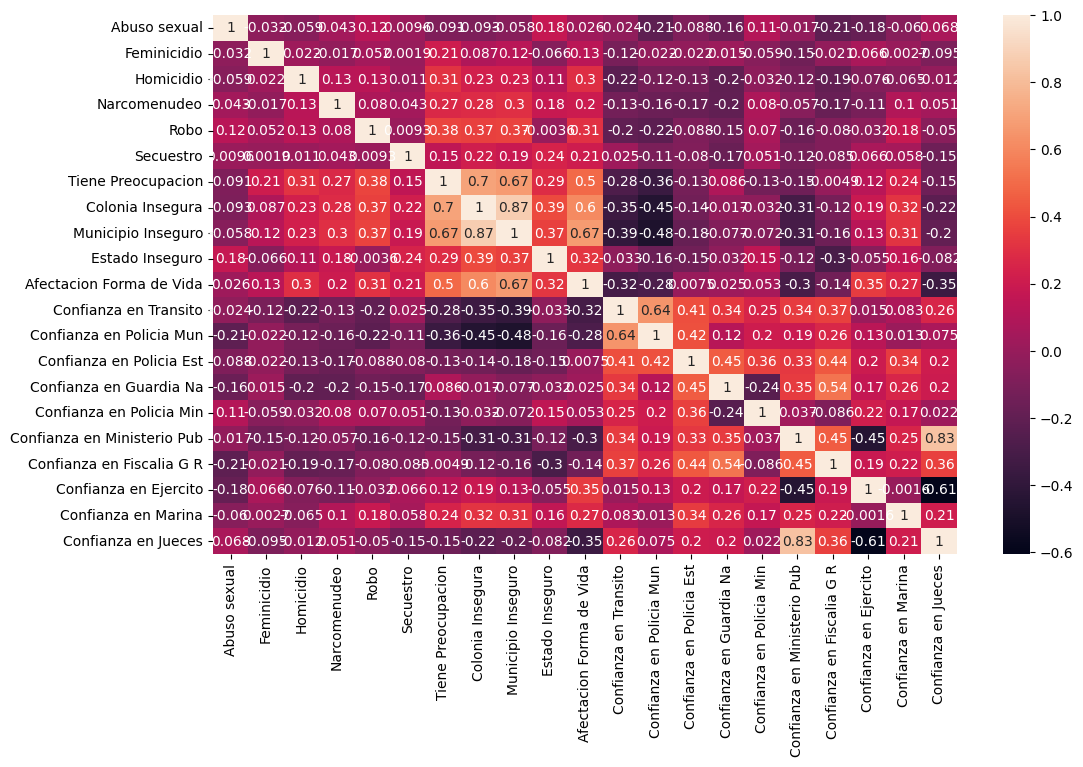

In [3]:
# Matriz de correlación

fig, ax = plt.subplots(figsize = (12, 7))

mc = seguridad_df[['Abuso sexual', 'Feminicidio', 'Homicidio', 'Narcomenudeo', 'Robo', 'Secuestro',
                   'Tiene Preocupacion', 'Colonia Insegura', 'Municipio Inseguro', 'Estado Inseguro',
                   'Afectacion Forma de Vida', 'Confianza en Transito', 'Confianza en Policia Mun', 
                   'Confianza en Policia Est', 'Confianza en Guardia Na', 'Confianza en Policia Min', 
                   'Confianza en Ministerio Pub', 'Confianza en Fiscalia G R', 'Confianza en Ejercito',
                   'Confianza en Marina', 'Confianza en Jueces']]

corr = mc.corr()
sns.heatmap(corr, annot = True)

De revisar la matriz de correlación en formato de *Heat Map* podemos encontrar algunas relaciones como por ejemplo: 
* La confianza en las autoridades municipales `Confianza en Policia Mun` tiene una fuerte correlación negativa con la percepción de inseguridad en las colonias `Colonia Insegura` y en el municipio `Municipio Inseguro`.
* La percepción de la inseguridad en el municipio `Municipio Inseguro` tiene una fuerte correlación postiva con la afectación a la forma de vida `Afectación Forma de Vida`. 

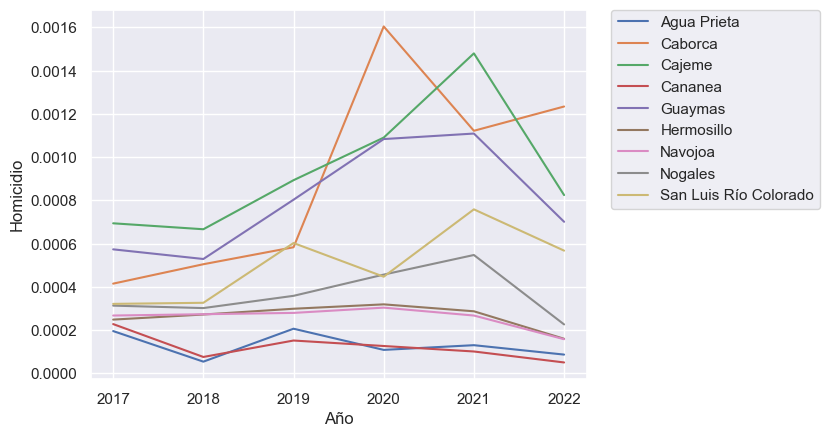

In [4]:
# Comportamiento en el tiempo de Homicidios por Municipio

sns.set_theme(style="darkgrid")

# Seleccionamos solo algunos Municipios de Sonora de los cuales nos interesa ver el crecimiento en la tasa de homicidios.
Homicidios = seguridad_df.loc[seguridad_df['Municipio'].isin([
    'Hermosillo', 'Cajeme', 'Navojoa', 'Guaymas', 'Nogales', 
    'San Luis Río Colorado', 'Cananea', 'Agua Prieta', 'Caborca'])]

sns.lineplot(x="Año", y="Homicidio",
             hue="Municipio",
             data=Homicidios)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

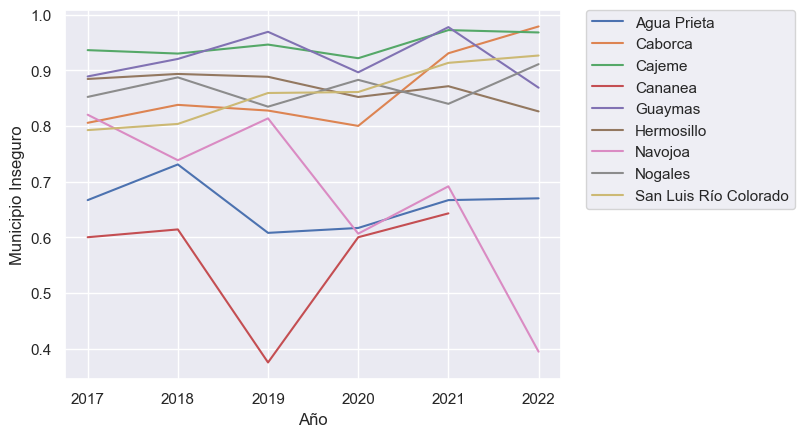

In [5]:
# Comportamiento de la Percepción de Inseguridad en Municipio por Año

sns.set_theme(style="darkgrid")

# Seleccionamos solo algunos Municipios de Sonora de los cuales nos interesa ver el comportamiento en la percepcion de inseguridad.
Inseguridad = seguridad_df.loc[seguridad_df['Municipio'].isin([
    'Hermosillo', 'Cajeme', 'Navojoa', 'Guaymas', 'Nogales', 
    'San Luis Río Colorado', 'Cananea', 'Agua Prieta', 'Caborca'])]

sns.lineplot(x="Año", y="Municipio Inseguro",
             hue="Municipio",
             data=Inseguridad)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

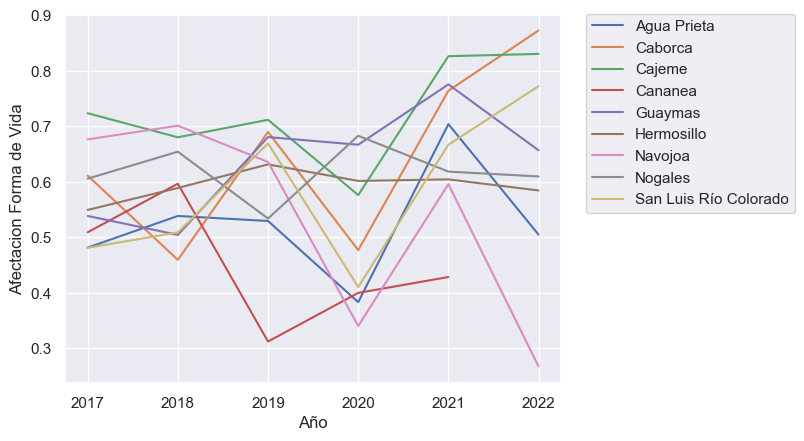

In [6]:
# Afectación a la forma de vida en Municipio por año.

sns.set_theme(style="darkgrid")

# Seleccionamos solo algunos Municipios de Sonora de los cuales nos interesa ver la afectación de la forma de vida.
Afectacion = seguridad_df.loc[seguridad_df['Municipio'].isin([
    'Hermosillo', 'Cajeme', 'Navojoa', 'Guaymas', 'Nogales', 
    'San Luis Río Colorado', 'Cananea', 'Agua Prieta', 'Caborca'])]

sns.lineplot(x="Año", y="Afectacion Forma de Vida",
             hue="Municipio",
             data=Afectacion)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# Analisis de Componentes principales (PCA) para reducción de caracteristicas.
Separamos nuestro dataframe `seguridad_df` en dos, uno para incluir las caracteristicas sobre delincuencia (`inseguridad`) y otro para incluir los datos de percepcion (`percepcion`). y sobre ambos realizamos dos visualizaciones en 2 dimensiones con PCA.

In [64]:
inseguridad = seguridad_df[['Abuso sexual', 'Feminicidio', 'Homicidio', 
                            'Narcomenudeo', 'Robo', 'Secuestro']]
percepcion = seguridad_df[['Tiene Preocupacion', 'Colonia Insegura', 
                           'Municipio Inseguro', 'Estado Inseguro', 
                           'Afectacion Forma de Vida', 'Confianza en Transito', 
                           'Confianza en Policia Mun', 'Confianza en Policia Est', 
                           'Confianza en Guardia Na', 'Confianza en Policia Min', 
                           'Confianza en Ministerio Pub', 'Confianza en Fiscalia G R', 
                           'Confianza en Ejercito', 'Confianza en Marina', 
                           'Confianza en Jueces']]

inseguridad = inseguridad.dropna()
percepcion = percepcion.dropna()

In [65]:
sns.set()

scaler = StandardScaler()
ins_norm = scaler.fit_transform(inseguridad)

pca = PCA(2)  # project from 6 to 2 dimensions
projected = pca.fit_transform(ins_norm)
print(inseguridad.shape)
print(projected.shape)
print(pca.components_)
print(pca.explained_variance_)

(432, 6)
(432, 2)
[[ 0.25171539  0.10274514  0.5287699   0.52372214  0.59230136  0.14621702]
 [ 0.79040359 -0.3248856  -0.47618292 -0.06210681  0.19733909  0.01270277]]
[1.25212094 1.0790595 ]


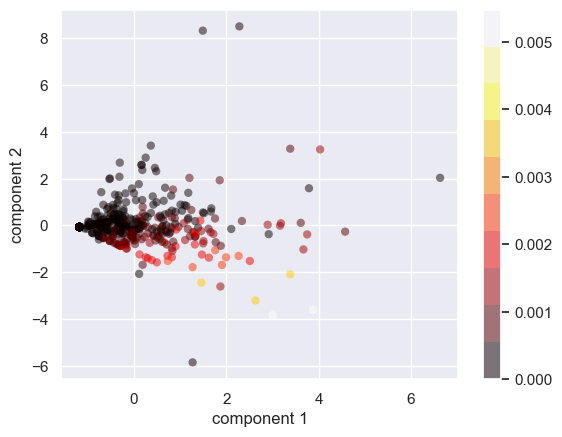

In [66]:
plt.scatter(projected[:, 0], projected[:, 1], 
            c=inseguridad.Homicidio, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('hot', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [67]:
sns.set()

scaler = StandardScaler()
perc_norm = scaler.fit_transform(percepcion)

pca = PCA(2)  # project from 15 to 2 dimensions
projected2 = pca.fit_transform(perc_norm)
print(inseguridad.shape)
print(projected2.shape)
print(pca.components_)
print(pca.explained_variance_)

(432, 6)
(118, 2)
[[-0.30666243 -0.37743274 -0.38711538 -0.19919969 -0.3273204   0.30541033
   0.29470049  0.21161865  0.13730631  0.05246189  0.30085116  0.22079636
  -0.11247208 -0.03229476  0.25953468]
 [-0.26835269 -0.25988745 -0.23547799 -0.11301733 -0.23972742 -0.17280869
  -0.05009327 -0.36175659 -0.38415359 -0.08454427 -0.24406223 -0.3487571
  -0.1167315  -0.43341356 -0.18471637]]
[4.50772028 2.71626421]


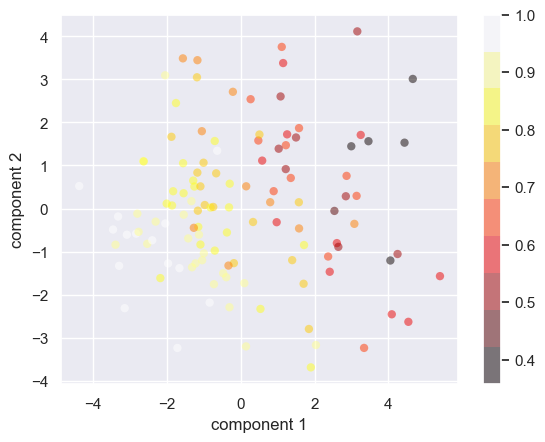

In [68]:
plt.scatter(projected2[:, 0], projected2[:, 1], 
            c=percepcion['Municipio Inseguro'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('hot', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();